<img style="float: left; margin-bottom: 1em" src="images/excelerate.png" width="200">
<img style="float: right; margin-bottom: 1em" src="images/surfsara.png" width="150">
<hr style="clear: both"/>

# Improving neural networks
In this notebook you will work on improving a neural network on a new data set. This data set is taken from the [PCam](https://github.com/basveeling/pcam) dataset, and consists of a thousand patches taken from a much larger histopathological slices of lymph node sections.

Each patch will either have metastatic (cancerous) tissue or not. As in the previous notebooks, your task is to train a network that will solve this classification task.

Let's load the data, and plot the first 16 images:

Using TensorFlow backend.


(10000, 96, 96, 3)
(array([0, 1]), array([515, 485]))
Data set size: (1000, 96, 96, 3)


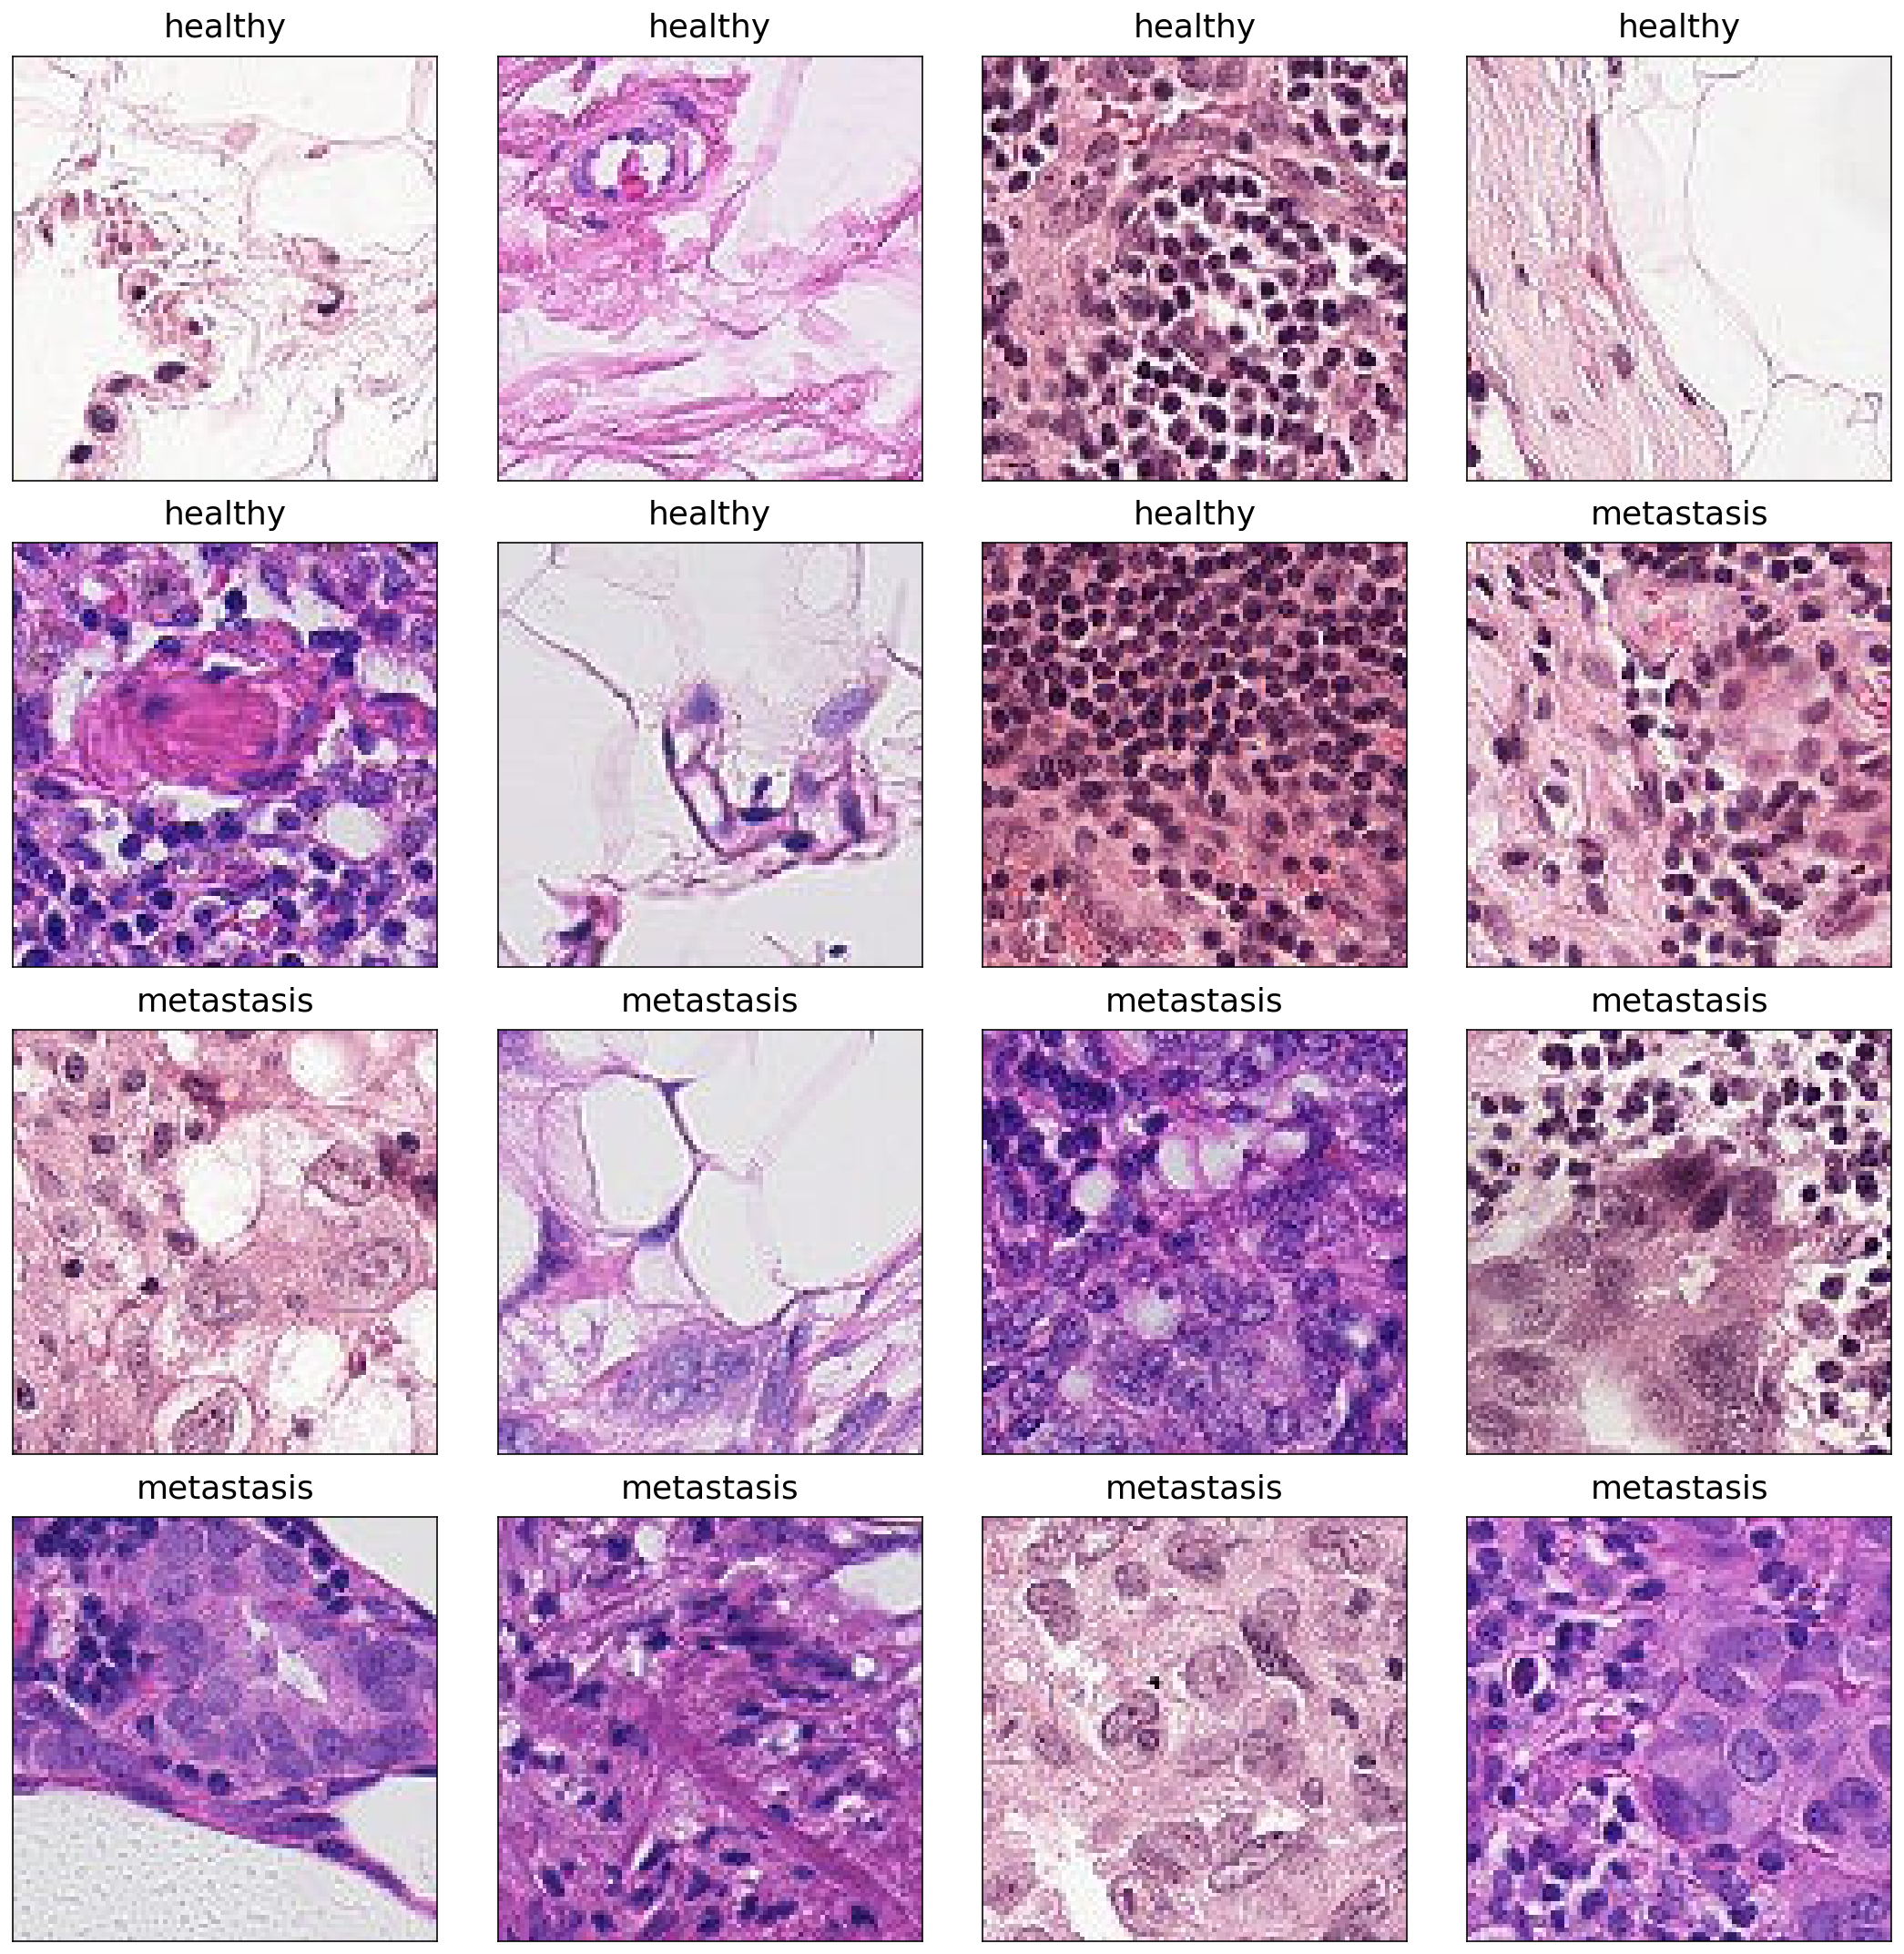

In [1]:
import lib
import keras

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

X, Y, labels = lib.dataset_pcam()

X = X[:1000]
Y = Y[:1000]

print('Data set size: {}'.format(X.shape))

lib.plot_examples(X[:16], Y[:16], labels);

Let's train a dense network to serve as a performance baseline. We can use it to compare to more advanced architectures like CNNs. Run the next cell and take note of the final accuracy on the training set.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 27648)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              28312576  
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 514       
Total params: 28,969,218
Trainable params: 28,969,218
Non-trainable params: 0
_________________________________________________________________
Train on 800 samples, validate on 200 samples
Epoch 1/25
800/800 [==============================] - 6s 8ms/step - loss: 0.6920 - a

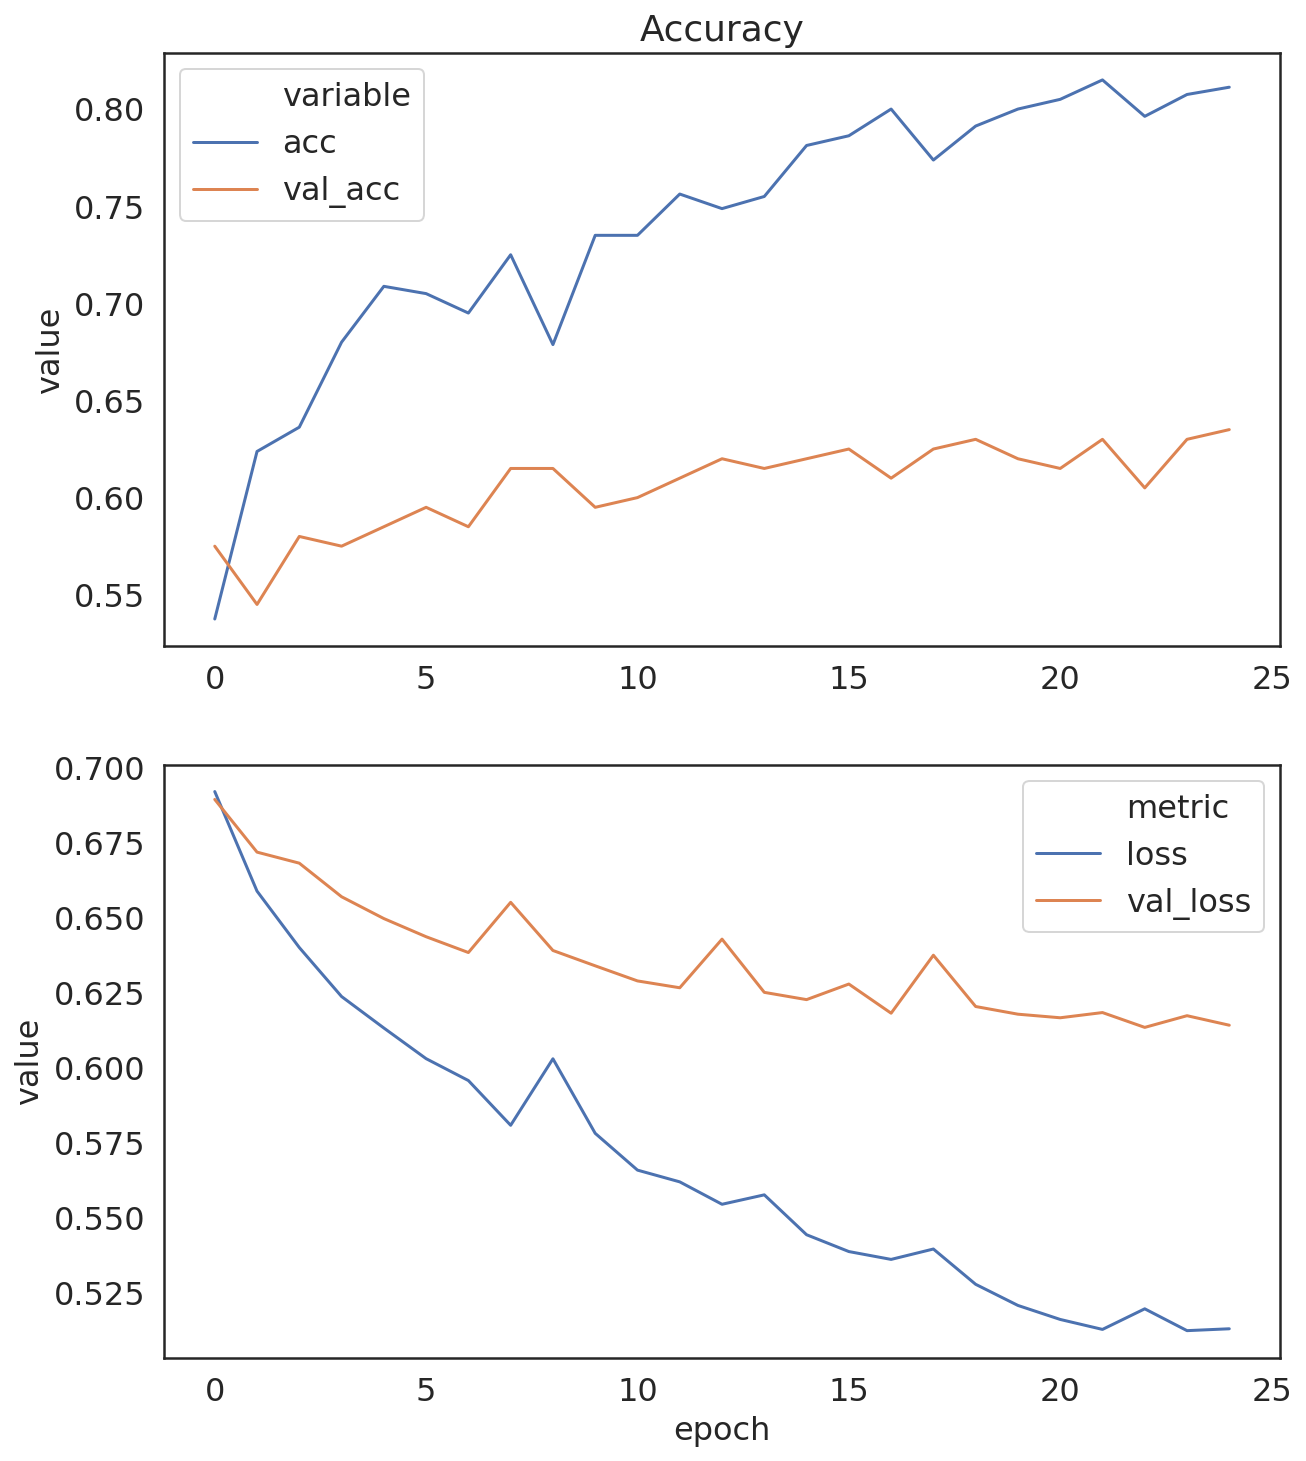

In [4]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Flatten(input_shape=X.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(Adam(lr=0.000001), loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X, Y, validation_split=0.2, epochs=25, batch_size=32)
lib.plot_history(history);

## Exercise 1
Now implement a CNN to solve the problem by filling out the skeleton below.

How does a CNN perform on this dataset compared with a dense network? Why do you think it performs worse or better?

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=X.shape[1:]))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Add additional conv and max pool layers here

# Add one or more dense layers here

model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(Adam(lr=<FILL IN>), loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X, Y, validation_split=0.2, epochs=25, batch_size=32)
lib.plot_history(history);

In [11]:
# PLEASE FILL IN YOUR ANSWER HERE

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 94, 94, 16)        448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         73856     
__________

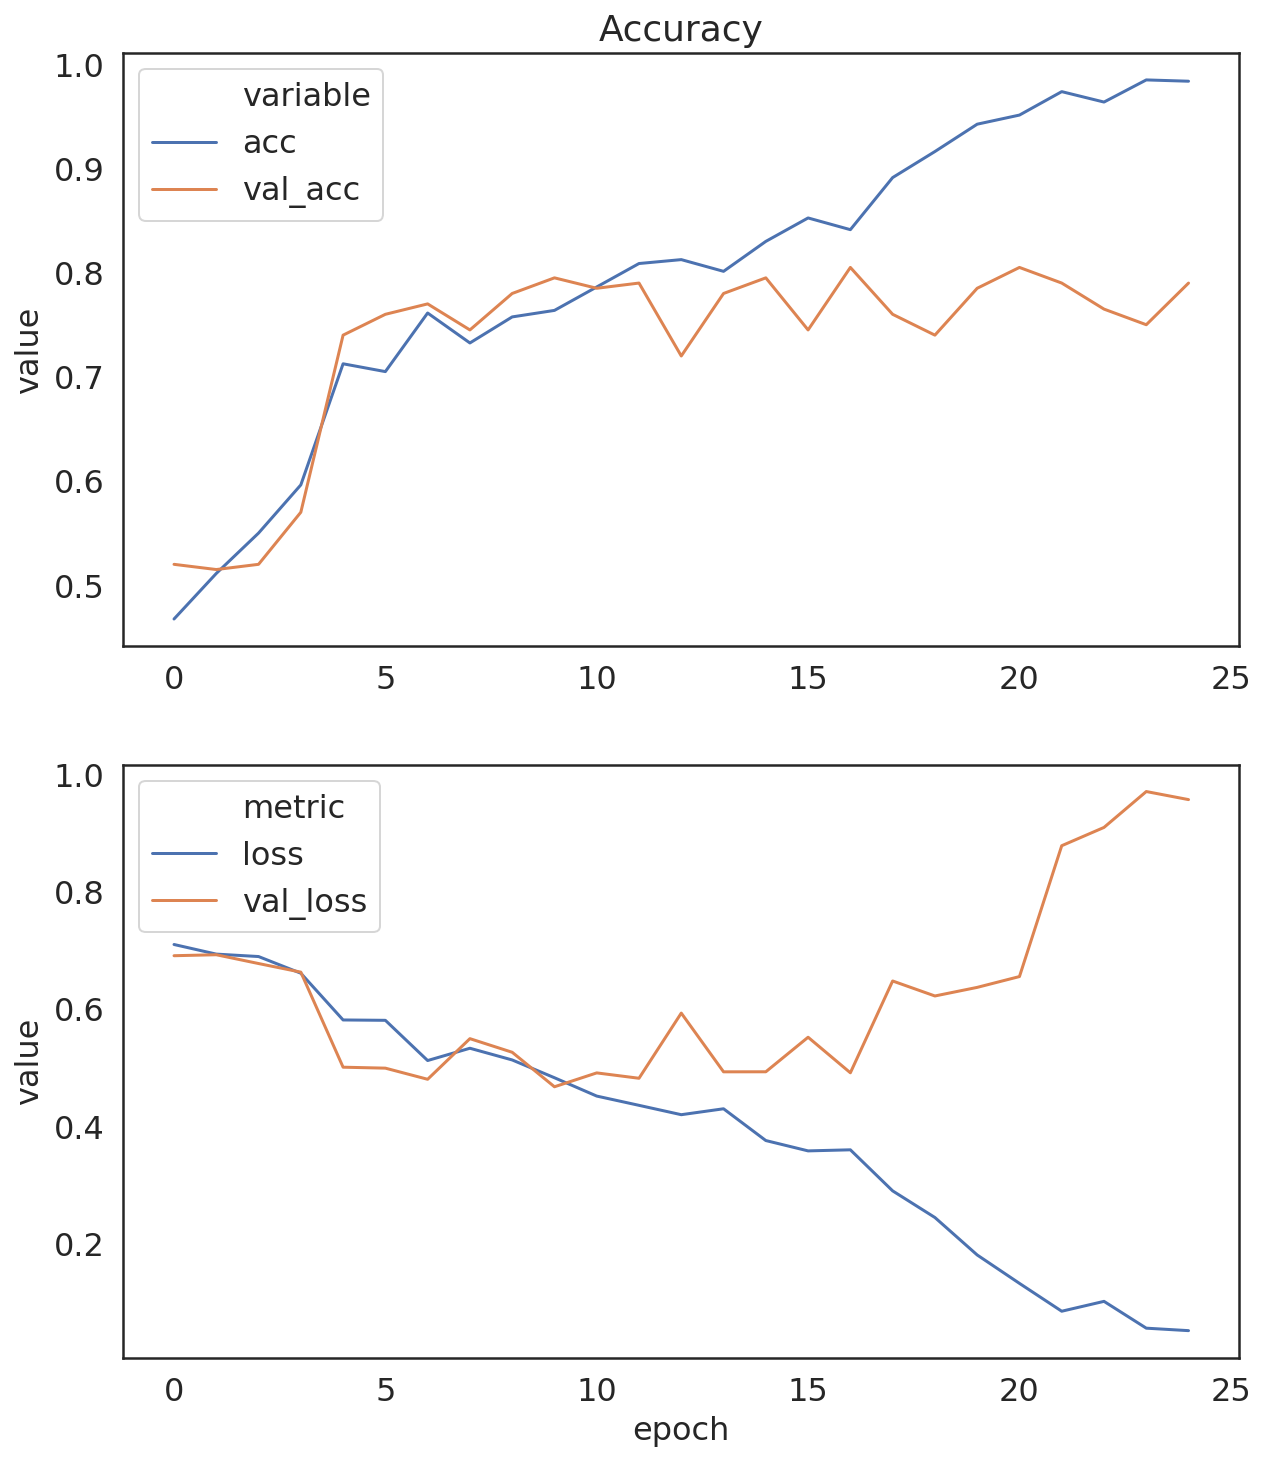

In [6]:
# SOLUTION

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=X.shape[1:]))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X, Y, validation_split=0.2, epochs=25, batch_size=32)
lib.plot_history(history);

**Answer**: because we are very much looking for local patterns that tell us whether this is metastasised tissue or not, CNNs have a big advantage over dense networks. This is evident from the final accuracies from the dense network and the CNN: 0.81 versus 0.98!

## Exercise 2
Inspect the class activation maps for the different layers by running the next cell. Do they make sense?

/opt/conda/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/opt/conda/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


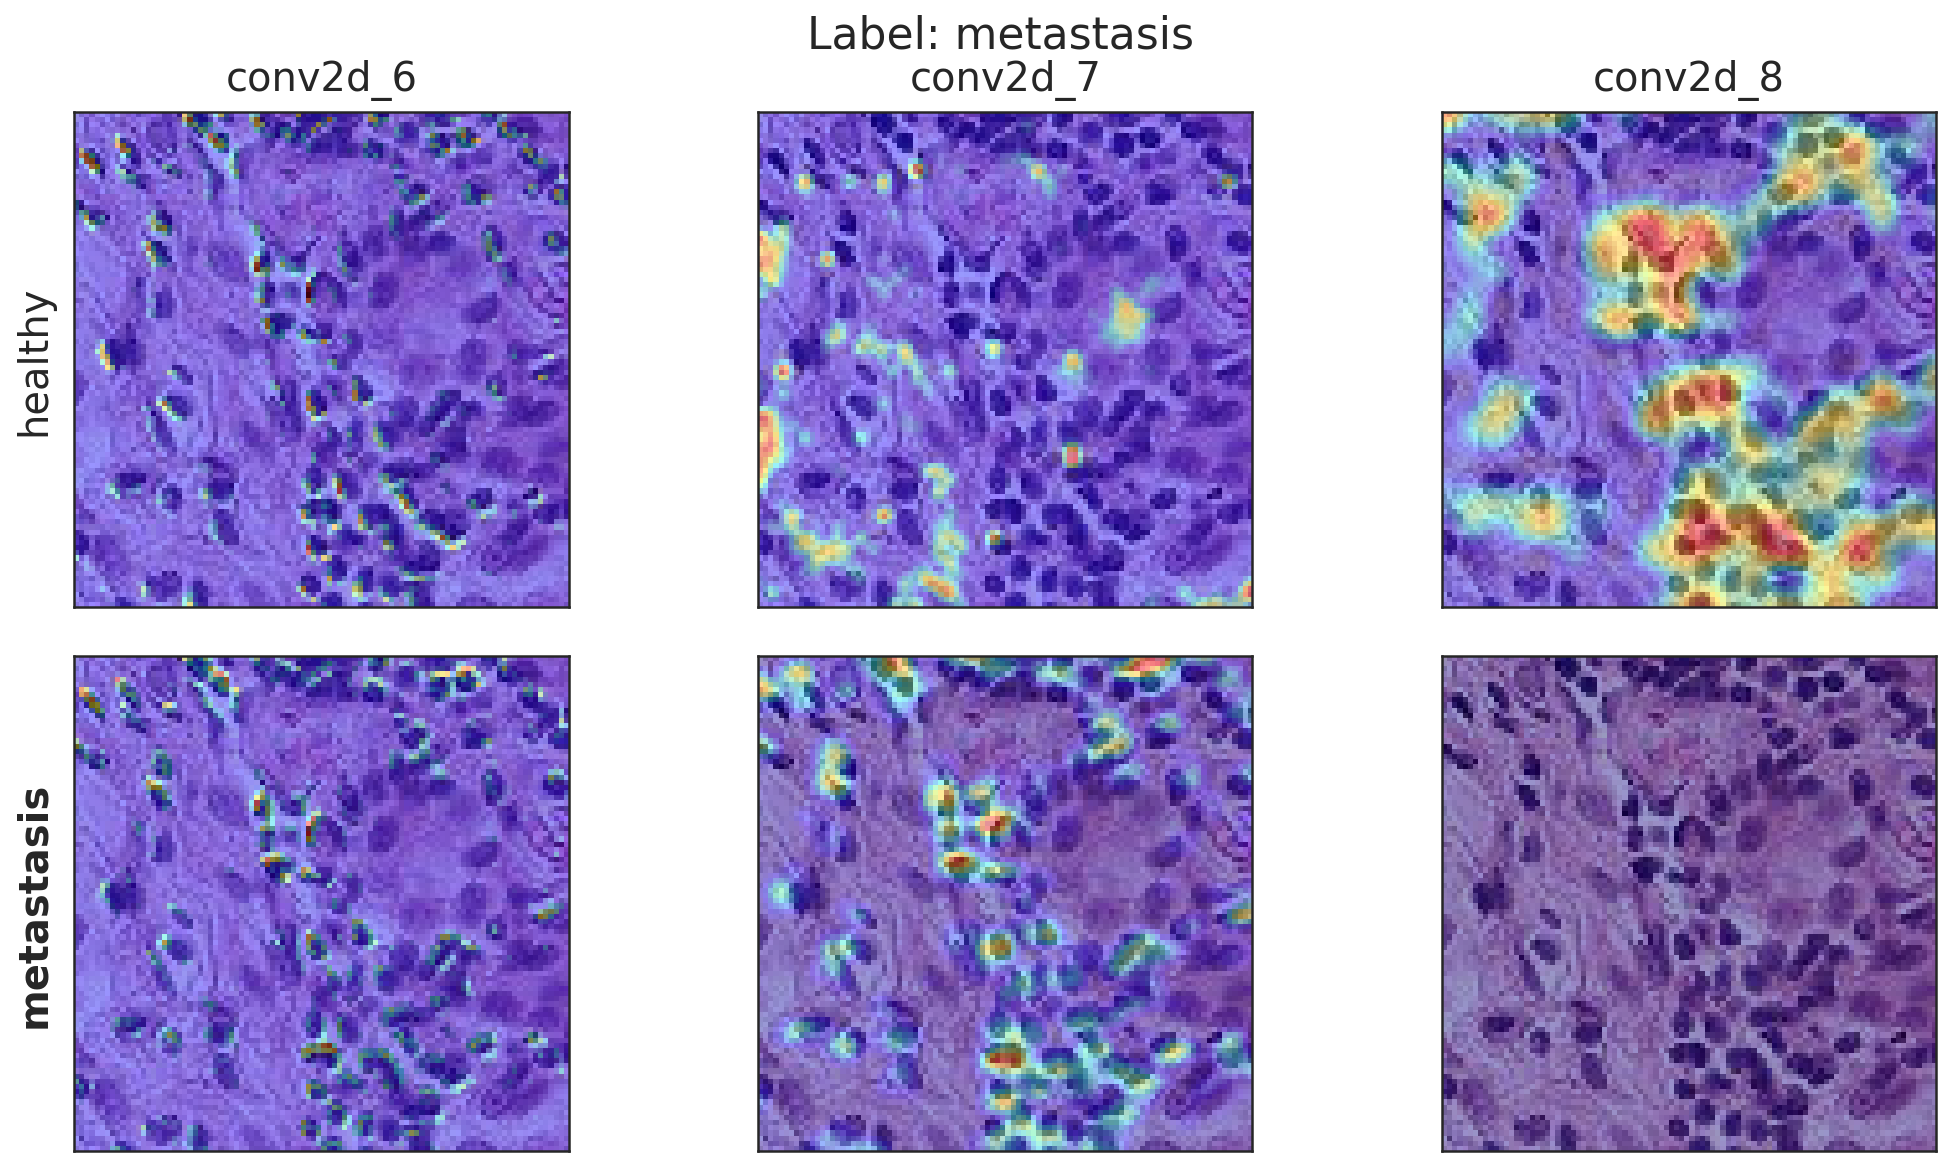

In [8]:
example_index = 1
lib.plot_cam(model, X[example_index], np.argmax(Y[example_index]), labels);

**Answer**: the image above shows you that the metastasis class is predicted based on very small patterns inside the smaller, darker pockets in the tissue.

## Exercise 3
Although the network is performing quite well, we can speed up convergence by adding **batch normalisation** layers. We add those between the convolutional layers and the max pooling layers.

In the next cell we import the batch normalisation layer, called [`BatchNormalization`](https://keras.io/layers/normalization/) in Keras. Copy-paste the network you trained in exercise 3 into the cell below, and add the batch normalisation layers **between the `Conv2D` and `MaxPool2D` layers**.

Rerun the training. How do the layers affect the convergence speed? Why do you think that is?

In [19]:
from keras.layers import BatchNormalization

# COPY-PASTE YOUR NETWORK FROM EXERCISE 3 HERE, AND ADD THE BATCH NORMALISATION LAYERS

In [21]:
# FILL IN YOUR ANSWER HERE

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 45, 45, 64)        256       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 20, 20, 128)       73856     
__________

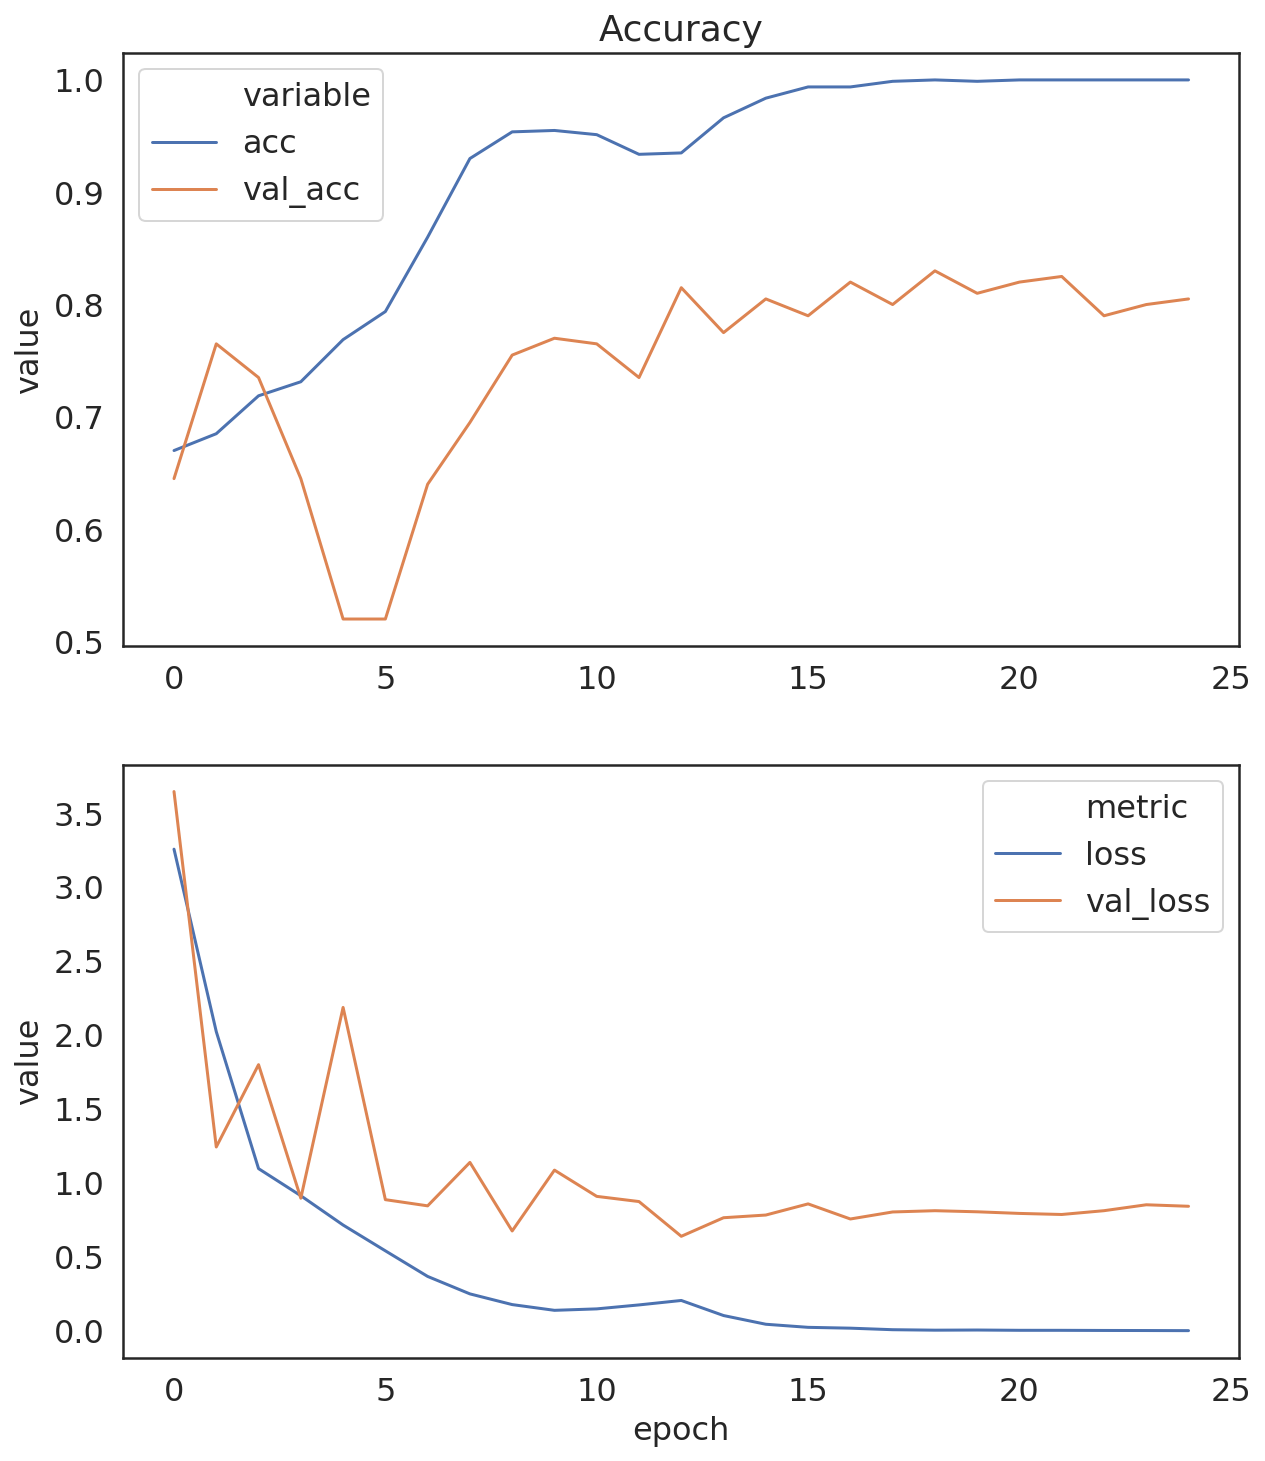

In [11]:
# SOLUTION

from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=X.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X, Y, validation_split=0.2, epochs=25, batch_size=32)
lib.plot_history(history);

**Answer**: during training, all parameters of the network are updated based on their contribution to the overall loss. This means that the output of a layer, its activations, will change as well. Since this output will be the input of a subsequent layer, this layer will need to take into account this changed input, as well as its own parameters. Essentially, we are trying to hit a moving target during training.

By normalising the activations in each batch, the inputs to the next layer will be from the same distribution. This means that we do not have to 'worry' anymore (or much less) about the changing activations, and that the optimisation can focus only on optimising the parameters of each layer itself.

In short, by adding batch normalisation after each activation, we are simplifying the optimisation problem. The immediate effect of this is to speed up the convergence: the training loss goes to zero very quickly compared with the CNN without batch normalisation you trained in exercise 1.

## Exercise 4
Look at the loss curves for the training and validation set in exercise 3. At what point does the model start overfitting? How can you tell?

Motivate your answer in the cell below.

In [22]:
# FILL IN YOUR ANSWER HERE

**Answer**: based on the loss curves, the network starts to overfit almost immediately after one or two epochs. The accuracy on the validation set stays relatively stable, though, so this does not directly have to impact real-world performance that badly.

## Exercise 5
Add dropout layers between the dense layers and train the network again. Use a fairly high rate (e.g. 0.5) of dropout and inspect the resulting validation and training loss curves. Does it have any effect? If so, how?

We have imported the dropout layer (simply called [`Dropout`](https://keras.io/layers/core/#dropout) in Keras) for you in the first line of the next cell. Copy-paste your original network from exercise 3 and add the dropout layers.

**Hint**: the dropout rate is a floating point number as the first parameter of `Dropout`.

In [ ]:
from keras.layers import Dropout

# COPY-PASTE YOUR NETWORK FROM EXERCISE 3 HERE, AND ADD THE DROPOUT LAYERS

In [ ]:
# FILL IN YOUR ANSWER HERE

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
batch_normalization_13 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
batch_normalization_14 (Batc (None, 45, 45, 64)        256       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 22, 22, 64)        0         
___________________________

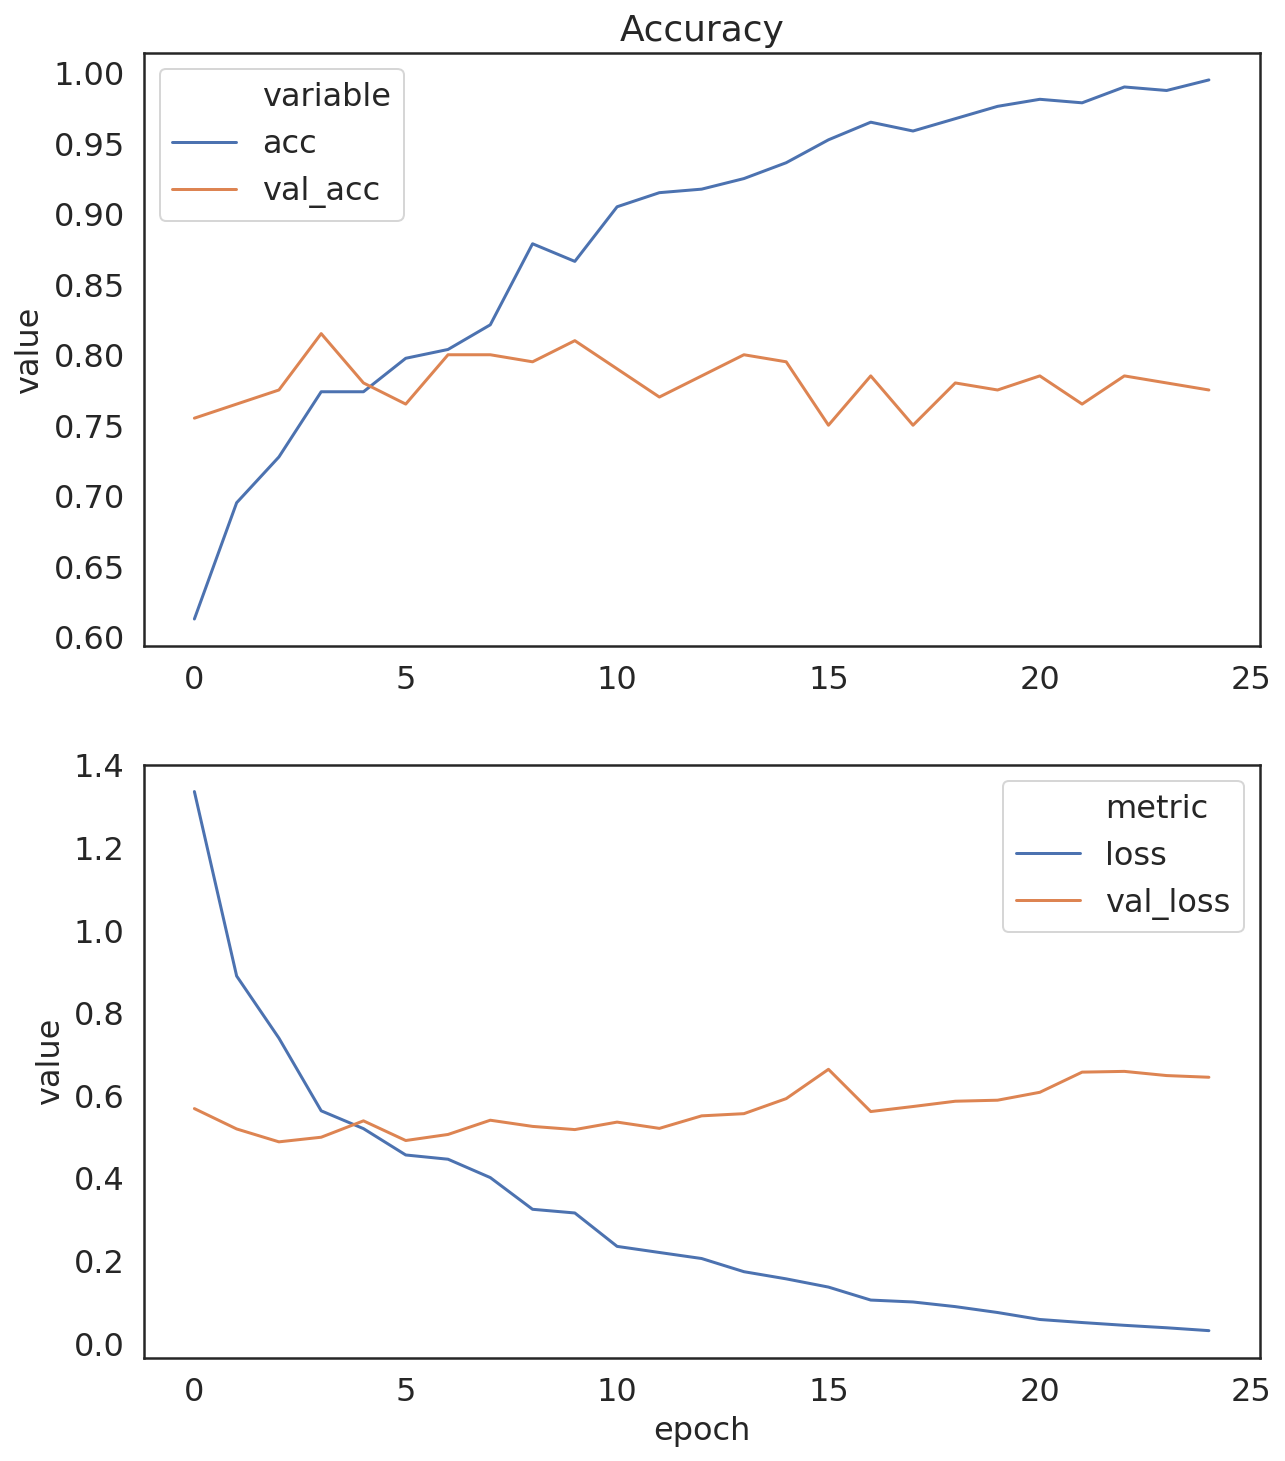

In [12]:
# SOLUTION

from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=X.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(Adam(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X, Y, validation_split=0.2, epochs=25, batch_size=32)
lib.plot_history(history);

**Answer**: the network will not converge as quickly, but we are able to control the converge, and hence overfitting, much better. You will see the validation loss decrease with the training loss for around five or six epochs, rather than increase almost immediately like it did in the previous exercise.

Studying the validation accuracies after each epoch, we can also see that they are slightly higher than the original network in some epochs. The difference can be as small as 1% or 2%, but this is still quite a significant difference.

## Exercise 6
We have regularised the dense part of the network by using dropout. We can do the same for the convolutional layers by penalising large weights in the filter kernels. We do this by adding an l2 regulariser on the kernel weights.

In the cell below we load the [`l2`](https://keras.io/regularizers) regulariser and add it to the first convolutional layer. For this we use the `kernel_regularizer` parameter in the `Conv2D` layer. In this example we set the strength of the regularization to 0.01. Depending on the data set and optimisation you may want to try different values.

Apply l2 regularisation to the kernels of all convolutional layers of your network from exercise 5, and rerun the training process. How can you tell we more effectively control overfitting now?

In [ ]:
# EXAMPLE:

from keras.regularizers import l2

model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=X.shape[1:], kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# COPY-PASTE THE REST OF YOUR NETWORK HERE, OR COPY THE kernel_regularizer PARAMETER TO YOUR OWN NETWORK

In [ ]:
# FILL IN YOUR ANSWER HERE

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
batch_normalization_17 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
batch_normalization_18 (Batc (None, 45, 45, 64)        256       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 20, 20, 128)       73856     
__________

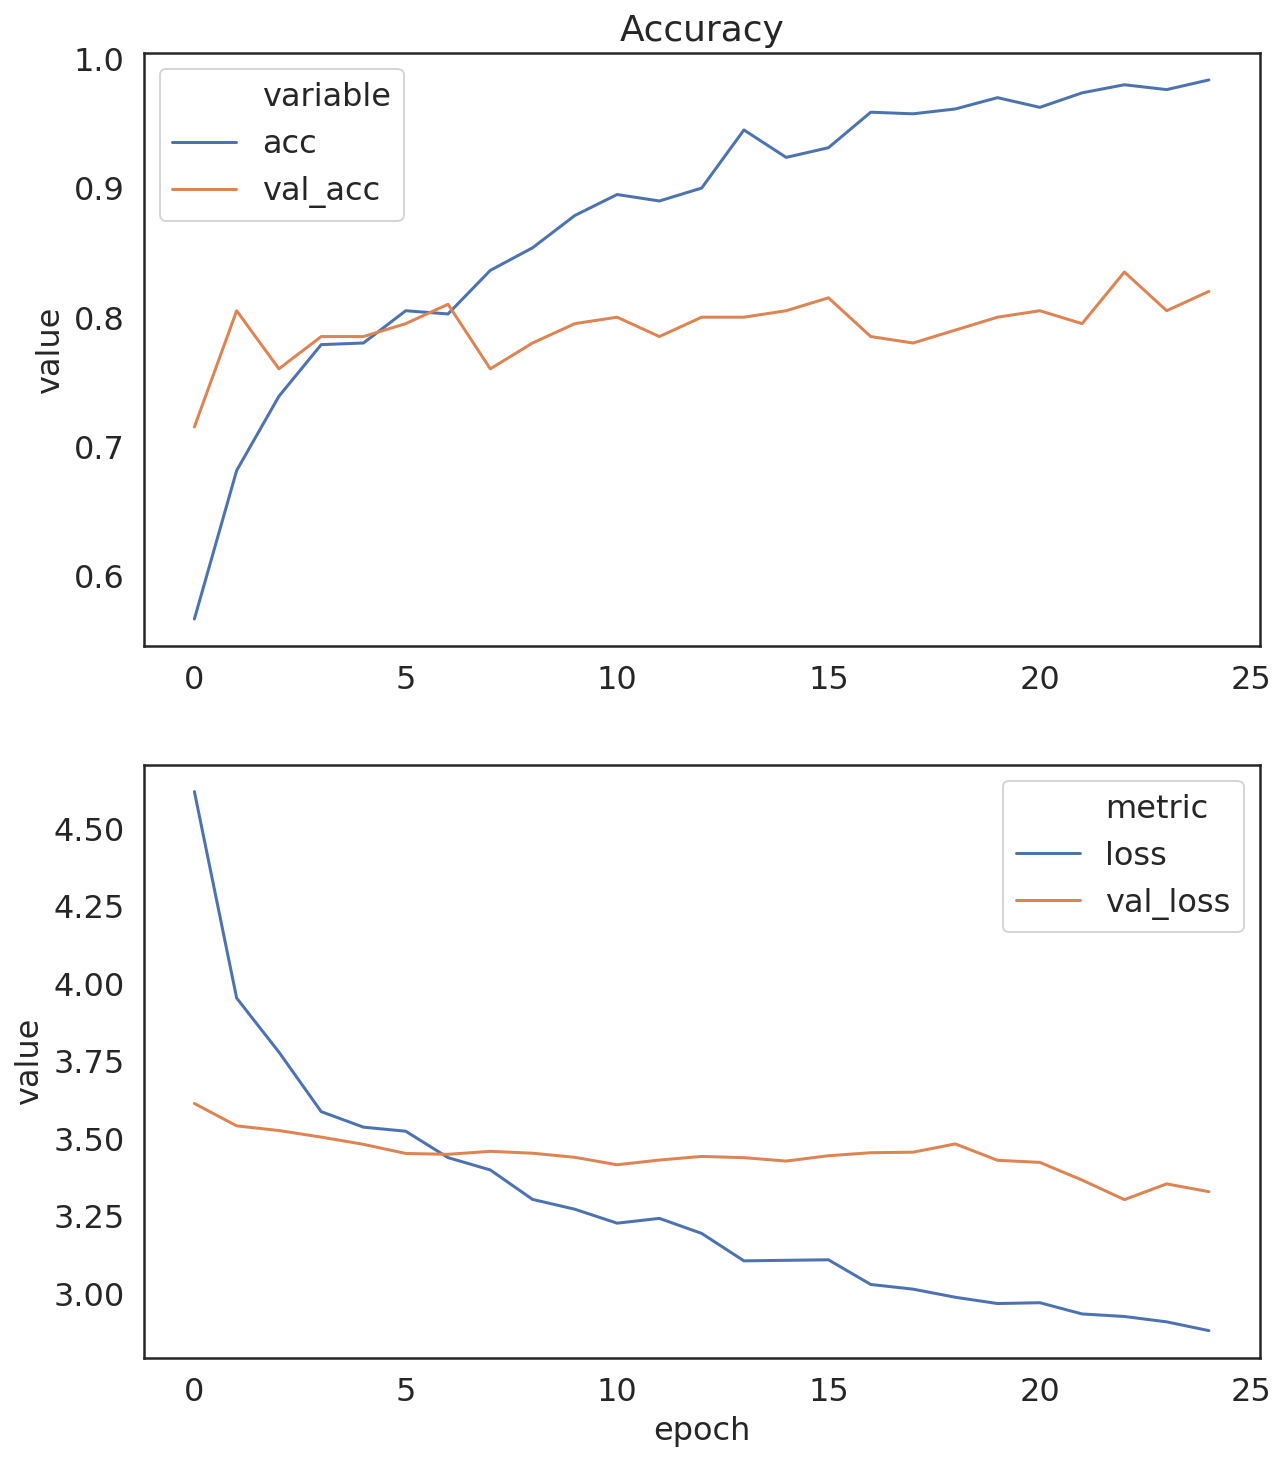

In [13]:
# SOLUTION

from keras.regularizers import l2
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=X.shape[1:], kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(Adam(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X, Y, validation_split=0.2, epochs=25, batch_size=64)
lib.plot_history(history);

**Answer**: the validation loss curve is still decreasing after 25 epochs, so even after 25 epochs we are still not overfitting! This is a huge change compared with the network without any dropout or l2 regularisation.

In this scenario, we would keep training to see if we reduce the validation loss even more. Also note that we do not necessarily get better validation accuracy compared with the dropout-only network.

## Exercise 9: bonus
Increase the regularisation strength (e.g. by an order of magnitude, going from 0.01 to 0.1) and/or increase the dropout rate. What happens with the convergence? Why is that? Motivate your answer in the cell below.

In [ ]:
# PLEASE COPY-PASTE YOUR NETWORK HERE FROM EXERCISE 8, AND MODIFY THE REGULARISATION STRENGTH AND/OR DROPOUT RATE

In [28]:
# PLEASE FILL IN YOUR ANSWER HERE

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
batch_normalization_49 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
batch_normalization_50 (Batc (None, 45, 45, 64)        256       
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 20, 20, 128)       73856     
__________

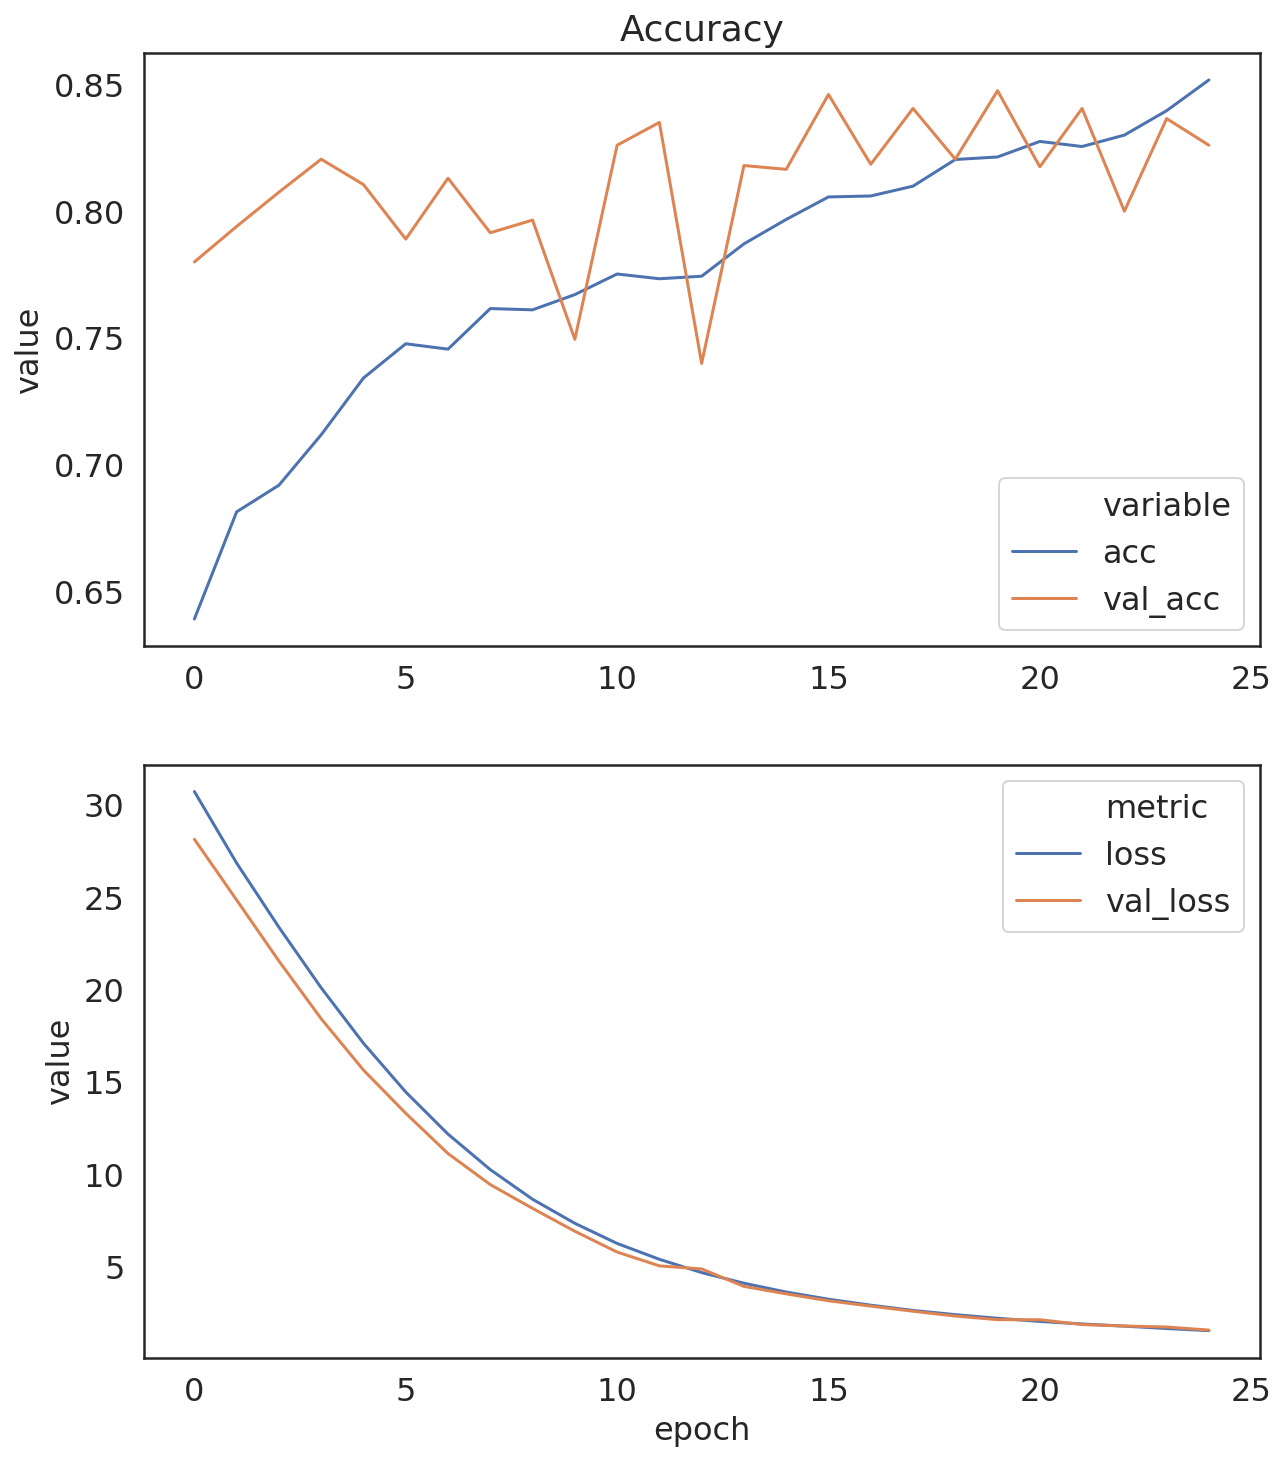

In [41]:
# SOLUTION

from keras.regularizers import l2
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=X.shape[1:], kernel_regularizer=l2(0.1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.75))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.75))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(Adam(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X, Y, validation_split=0.2, epochs=25, batch_size=64)
lib.plot_history(history);

**Answer**: in the example above we have increased the regularisation strength to from 0.01 to 0.1, and the dropout rate from 0.5 to 0.75. Even though we are regularising heavily, the network is still able to train, and training and validation loss are very close. What's more, the accuracies are quite close as well.

If we regularise too strongly, the network will be unable to learn and performance will drop. However, as you can see we can be strict and still generalise well, at the cost of increased training time.